# 中古マンション価格予想

In [15]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

from ml_wrap.data_loader.loader import SameCSVLoader 

from ml_wrap.data_loader.processor import (RemoveAllNullProcessor, 
                                             MultiDataProcessor,
                                             DataDropProcessor,
                                             RemoveOnePatternProcessor,
                                             JapaneseCalenderProcessor,
                                             DataReplaceProcessor,
                                             DataMapProcessor)

from ml_wrap.data_loader.report import ReportFactoryBase, LoggerReportFactory, ReportMakerBase
from ml_wrap.learn import XGBoostWrap, LightGBMWrap, CatBoostWrap
from ml_wrap.learn.divider import HoldOutDivider

import warnings
warnings.simplefilter('ignore')

pd.options.display.float_format = '{:.2f}'.format

plt.rcParams['font.family'] = 'MS Gothic'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
report_maker = ReportMakerBase.get_report_maker('NoteBookReportMaker')
# print(list(ReportMakerBase.__subclasses__()))

In [17]:
loader = SameCSVLoader("./sample_data/train")
data = loader.load()

In [18]:
pd.DataFrame(data._raw_data.columns).to_clipboard()

In [19]:
station_away_error_dict = {
    "30分?60分": '45',
    "1H?1H30": '75',
    "2H?": '120',
    "1H30?2H": '105'
}
area_error_dict = {
  "2000㎡以上": '2000'
}
build_year_error = {
  '戦前': '1945'
}
deal_year_error = {
    "年第1四半期": ".25",
    "年第2四半期": ".50",
    "年第3四半期": ".75",
    "年第4四半期": ".99",
}

processor = MultiDataProcessor(RemoveAllNullProcessor(),
                               DataDropProcessor("市区町村名"),
                               RemoveOnePatternProcessor(),
                               DataReplaceProcessor('最寄駅：距離（分）', station_away_error_dict),
                               DataReplaceProcessor('面積（㎡）', area_error_dict),
                               DataReplaceProcessor('建築年', build_year_error, after_type=str),
                               DataReplaceProcessor('取引時点', deal_year_error),
                               JapaneseCalenderProcessor('建築年', float),
                               DataMapProcessor('建築年', lambda x: datetime.now().year - x, float))


In [20]:
processed_data = processor.process(data)
report_maker.show_basic_info(processed_data)

,types,count,non-null-count,null-count,null%,max,min,mean,std,unique-count,top10 val
ID,int64,751560,751560,0,0.00,47036844.00,1000007.00,18507374.29,9562455.90,751560,"(1020026, 1, '0%'),(23003198, 1, '0%'),(230102..."
市区町村コード,int64,751560,751560,0,0.00,47213.00,1101.00,18525.02,9592.10,619,"(13111, 14872, '2%'),(13108, 14053, '2%'),(131..."
都道府県名,object,751560,751560,0,0.00,NaN,NaN,NaN,NaN,47,"('東京都', 226630, '30%'),('神奈川県', 106596, '14%')..."
地区名,object,751560,750890,670,0.09,NaN,NaN,NaN,NaN,12215,"('本町', 6245, '1%'),('中央', 4216, '1%'),('栄町', 2..."
最寄駅：名称,object,751560,748788,2772,0.37,NaN,NaN,NaN,NaN,3881,"('川崎', 2914, '0%'),('勝どき', 2431, '0%'),('浜松', ..."
最寄駅：距離（分）,float64,751560,728362,23198,3.09,120.00,0.00,11.64,12.16,34,"(6.0, 60570, '8%'),(4.0, 58550, '8%'),(5.0, 54..."
間取り,object,751560,724050,27510,3.66,NaN,NaN,NaN,NaN,66,"('３ＬＤＫ', 317710, '42%'),('１Ｋ', 111900, '15%'),..."
面積（㎡）,float64,751560,751560,0,0.00,2000.00,10.00,58.44,26.98,118,"(70.0, 98466, '13%'),(65.0, 92256, '12%'),(60...."
建築年,float64,751560,729671,21889,2.91,78.00,1.00,27.50,11.78,78,"(15.0, 25658, '3%'),(32.0, 25243, '3%'),(17.0,..."
建物の構造,object,751560,730717,20843,2.77,NaN,NaN,NaN,NaN,12,"('ＲＣ', 508829, '68%'),('ＳＲＣ', 215490, '29%'),(..."


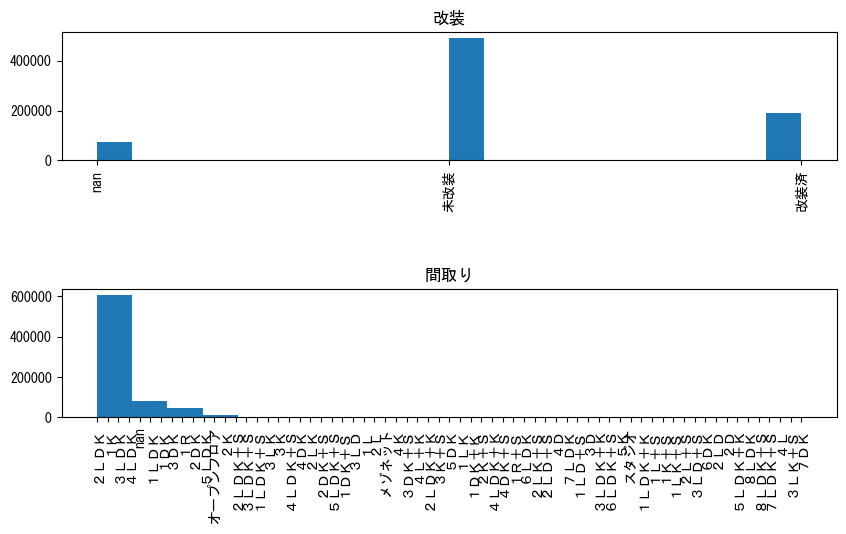

In [21]:
#0
#0	ID
#1	種類
#2	地域
#3	市区町村コード
#4	都道府県名
#5	市区町村名
#6	地区名
#7	最寄駅：名称
#8	最寄駅：距離（分）
#9	間取り
#10	面積（㎡）
#11	土地の形状
#12	間口
#13	延床面積（㎡）
#14	建築年
#15	建物の構造
#16	用途
#17	今後の利用目的
#18	前面道路：方位
#19	前面道路：種類
#20	前面道路：幅員（ｍ）
#21	都市計画
#22	建ぺい率（％）
#23	容積率（％）
#24	取引時点
#25	改装
#26	取引の事情等
#27	取引価格（総額）_log

# report_maker.show_raw_data(data)
# report_maker.show_basic_info(data)
report_maker.show_histogram(processed_data, '改装', '間取り', show_null=True, figure_size=(10, 5), width=1)

In [22]:
processed_data.target = '取引価格（総額）_log'

In [23]:
report_maker.define_colmns_enum(processed_data, '：', '（', '）', '㎡', '％')

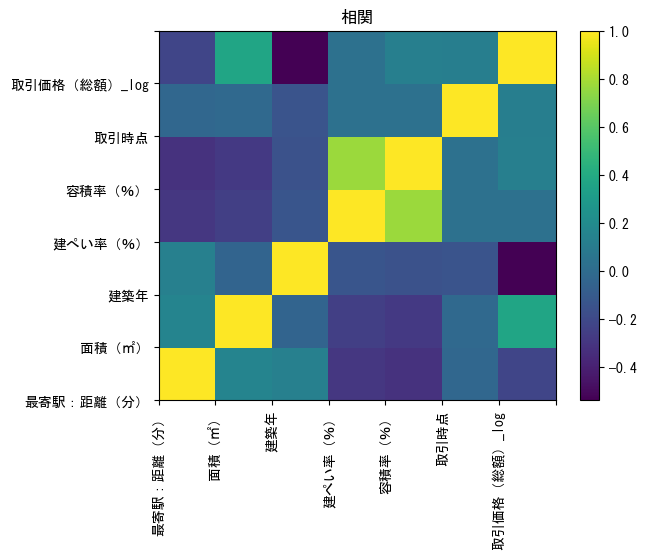

In [24]:
report_maker.show_correlation_heat(processed_data)

In [25]:
print(processed_data._raw_data)

            ID  市区町村コード 都道府県名    地区名    最寄駅：名称  最寄駅：距離（分）   間取り  面積（㎡）   建築年  \
0      1020026     1102   北海道  新琴似８条        麻生       6.00  ２ＬＤＫ  40.00 42.00   
1      1028771     1103   北海道  北３３条東       新道東        NaN  ２ＬＤＫ  70.00 24.00   
2      1044035     1105   北海道   平岸１条  平岸(札幌市営)       5.00  ２ＬＤＫ  70.00 49.00   
3      1090865     1203   北海道  朝里川温泉        朝里      45.00    １Ｋ  30.00 32.00   
4      1008219     1101   北海道   南８条西     西１８丁目      14.00  ３ＬＤＫ  65.00 49.00   
...        ...      ...   ...    ...       ...        ...   ...    ...   ...   
2165  47013370    47201   沖縄県     牧志        牧志        NaN  ２ＬＤＫ  90.00 13.00   
2166  47025915    47211   沖縄県     泡瀬       NaN        NaN  ３ＬＤＫ 115.00 17.00   
2167  47003483    47208   沖縄県    字港川       NaN        NaN  ４ＬＤＫ  85.00  7.00   
2168  47005366    47211   沖縄県     大里       NaN        NaN  ３ＬＤＫ  55.00 39.00   
2169  47023235    47201   沖縄県     壺川        壺川       8.00  ４ＬＤＫ  85.00 25.00   

     建物の構造   用途 今後の利用目的          都市計画  

In [26]:
%load_ext autoreload
%autoreload 2

from ml_wrap.learn import XGBoostWrap, LightGBMWrap, CatBoostWrap
from ml_wrap.learn.divider import HoldOutDivider
from ml_wrap.learn.data_def import Objective, EvalMetric

SEED = 1
processed_data.target = '取引価格（総額）_log'
processed_data.categories = ["都道府県名", 
                 "地区名", 
                 "最寄駅：名称", 
                 "間取り", 
                 "建物の構造", 
                 "用途", 
                 "今後の利用目的", 
                 "都市計画", 
                 "改装", 
                 "取引の事情等"]
xgb_wrap = XGBoostWrap(seed=SEED, objective=Objective.regression, eval_metric=EvalMetric.mae)
xgb_wrap.learn(processed_data, HoldOutDivider(seed=SEED))
# xgb_wrap = LightGBMWrap(seed=SEED)
# xgb_wrap.learn(processed_data, HoldOutDivider(seed=SEED))
# xgb_wrap = CatBoostWrap(seed=SEED)
# xgb_wrap.learn(processed_data, HoldOutDivider(seed=SEED))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[0]	train-mae:4.71193	valid-mae:4.71309
[5]	train-mae:0.79540	valid-mae:0.79582
[10]	train-mae:0.18355	valid-mae:0.18359
[15]	train-mae:0.12727	valid-mae:0.12723
[20]	train-mae:0.12138	valid-mae:0.12132
[25]	train-mae:0.11778	valid-mae:0.11774
[30]	train-mae:0.11574	valid-mae:0.11572
[35]	train-mae:0.11389	valid-mae:0.11395
[40]	train-mae:0.11242	valid-mae:0.11253
[45]	train-mae:0.11049	valid-mae:0.11065
[50]	train-mae:0.10895	valid-mae:0.10911
[55]	train-mae:0.10734	valid-mae:0.10754
[60]	train-mae:0.10661	valid-mae:0.10686
[65]	train-mae:0.10530	valid-mae:0.10556
[70]	train-mae:0.10486	valid-mae:0.10513
[75]	train-mae:0.10373	valid-mae:0.10400
[80]	train-mae:0.10267	valid-mae:0.10294
[85]	train-mae:0.10159	valid-mae:0.10187
[90]	train-mae:0.10086	valid-mae:0.10114
[95]	train-mae:0.10039	valid-mae:0.10070
[100]	train-mae:0.09963	valid-mae:0.09993
[105]	train-mae:0.09921	valid-mae:0.09951
[110]	trai

In [27]:
xgb_wrap.result[0].model.get_score()

{'ID': 10695.0,
 '市区町村コード': 3384.0,
 '都道府県名': 1298.0,
 '地区名': 6044.0,
 '最寄駅：名称': 5362.0,
 '最寄駅：距離（分）': 3130.0,
 '間取り': 1753.0,
 '面積（㎡）': 3671.0,
 '建築年': 5259.0,
 '建物の構造': 698.0,
 '用途': 586.0,
 '今後の利用目的': 424.0,
 '都市計画': 896.0,
 '建ぺい率（％）': 403.0,
 '容積率（％）': 1177.0,
 '取引時点': 2564.0,
 '改装': 736.0,
 '取引の事情等': 414.0}

In [12]:
%load_ext autoreload
%autoreload 2
from ml_wrap.learn import XGBoostWrap, LightGBMWrap, CatBoostWrap, ModelWrapBase
#xgb_wrap.get_evaluates()
xgb_wrap.log_loss()
# xgb_wrap.predict(processed_data._raw_data)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


NameError: name 'xgb_wrap' is not defined

In [15]:
r = xgb_wrap.result[0]
print(r.validation_obj)
print(type(r.validation_obj))
print(len(r.validation_obj))
preds = xgb_wrap._predict(r.model, r.validation_exp)
print(preds)
print(type(preds))
print(len(preds))

14214    7.26
27246    7.26
4472     7.41
885      7.18
15467    7.23
         ... 
16939    7.28
112717   7.99
29951    7.76
72164    7.60
31298    7.11
Name: 取引価格（総額）_log, Length: 187890, dtype: float64
<class 'pandas.core.series.Series'>
187890
[1. 1. 1. ... 1. 1. 1.]
<class 'numpy.ndarray'>
187890
